# datadrift_without_dimension-reduction
기존 고차원 데이터에서 차원축소를 적용하고 데이터 드리프트 시각화

## 0. Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch

import re

import warnings
warnings.filterwarnings(action='ignore')

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

seed = 1234
set_seed(seed)

In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [5]:
# Hugging Face의 병렬 처리가 비활성화
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[64, 128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

In [7]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity_distance(vector1, vector2, label1="Vector1", label2="Vector2"):

    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    plt.tight_layout()
    plt.show()


## 1. Load Data

In [8]:
law_train = pd.read_csv('../dataset_law/data/train_data.csv')
law_valid = pd.read_csv('../dataset_law/data/val_data.csv')
law_test = pd.read_csv('../dataset_law/data/test_data.csv')

In [13]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")

test_data = data_cn['test']
test = pd.DataFrame(test_data)
lbox_test = test[['casetype', 'casename', 'facts']]

0000.parquet:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

(…)e_classification/validation/0000.parquet:   0%|          | 0.00/739k [00:00<?, ?B/s]

(…)asename_classification/test/0000.parquet:   0%|          | 0.00/743k [00:00<?, ?B/s]

(…)sename_classification/test2/0000.parquet:   0%|          | 0.00/890k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test2 split:   0%|          | 0/1294 [00:00<?, ? examples/s]

In [10]:
law_train.head(2)

,class,text
0,i,2) 또한 자동차 열쇠에 대한 배타적인 점유를 취득하는 이상 인근에 주차된 해당 자...
1,w,자기의 행위로 인하여 타인의 사망이라는 결과를 발생시킬 만한 가능성 또는 위험이 있...


In [11]:
law_valid.head(2)

,class,text
0,i,"피해자가 입은 상해의 부위 및 정도는 사망에 이를 수 있는 정도의 위험한 수준이었고,"
1,c,이 사건 범행 당시 피고인에게 미필적으로나마 살인의 범의가 있었음을 충분히 인정할 ...


In [14]:
lbox_test.head(2)

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."


## 2. Embedding

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
# KLUE RoBERTa 모델과 토크나이저 설정
from transformers import AutoModel, AutoTokenizer

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name).to(device)

2024-12-09 12:23:33.812559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:23:33.886880: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 12:23:33.888654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-09 12:23:33.888665: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

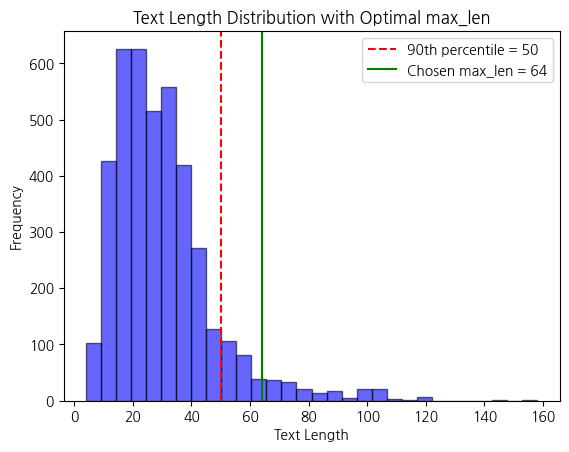

In [10]:
# max_len 길이 구하기
token_lengths = [len(tokenizer.encode(text)) for text in law_train["text"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

In [11]:
from torch.utils.data import DataLoader, Dataset

# 1. 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # `text` 또는 `facts` 열 자동 선택
        self.column_name = 'text' if 'text' in dataframe.columns else 'facts'
        self.texts = self.data[self.column_name]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts.iloc[idx]
    
# 2. 데이터셋 준비
train_dataset = CustomDataset(law_train)
valid_dataset = CustomDataset(law_test)
test_dataset = CustomDataset(lbox_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# 3. 임베딩 생성 함수
def generate_embeddings(data_loader):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=max_len).to("cuda")
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩 사용
            embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings).numpy()

# 데이터 임베딩 생성
train_embeddings = generate_embeddings(train_loader)
valid_embeddings = generate_embeddings(valid_loader)
test_embeddings = generate_embeddings(test_loader)

## 3. Dimenension Reduction

### settings for detecting datadrift

In [13]:
# MMD
import pandas as pd
from evidently.metrics import EmbeddingsDriftMetric
from evidently.report import Report
from evidently.metrics.data_drift.embedding_drift_methods import mmd
from evidently import ColumnMapping

def mmd_scores(train_reduced, valid_reduced, test_reduced, threshold=0.015):
    """
    Train과 Valid, Train과 Test 간의 드리프트 점수를 계산하여 반환.

    Parameters:
    - train_reduced: Train 데이터의 reduced 결과 (numpy array)
    - valid_reduced: Valid 데이터의 reduced 결과 (numpy array)
    - test_reduced: Test 데이터의 reduced 결과 (numpy array)
    - threshold: MMD에서 사용하는 드리프트 탐지 임계값 (default=0.015)

    Returns:
    - dict: Train vs Valid, Train vs Test의 드리프트 점수를 포함한 딕셔너리
    """
    # Reference 데이터프레임 생성
    reference_df = pd.DataFrame(train_reduced, 
                                columns=[f"dim_{i}" for i in range(train_reduced.shape[1])])
    # Valid 데이터프레임 생성
    valid_df = pd.DataFrame(valid_reduced, 
                            columns=[f"dim_{i}" for i in range(valid_reduced.shape[1])])
    # Test 데이터프레임 생성
    test_df = pd.DataFrame(test_reduced, 
                           columns=[f"dim_{i}" for i in range(test_reduced.shape[1])])
    
    # ColumnMapping 정의
    column_mapping = ColumnMapping(
        embeddings={'all_dimensions': reference_df.columns}  # 전체 열을 포함
    )

    # MMD 기반 드리프트 계산 함수
    def get_drift_score(reference_df, current_df):
        report = Report(metrics=[
            EmbeddingsDriftMetric(
                'all_dimensions',
                drift_method=mmd(
                    threshold=threshold,
                    bootstrap=None,
                    quantile_probability=0.95,
                  #  reduced_components=None
                )
            )
        ])
        report.run(reference_data=reference_df, current_data=current_df, column_mapping=column_mapping)
        drift_result = report.as_dict()
        return round(drift_result["metrics"][0]["result"]["drift_score"],4)

    # Train vs Valid 드리프트 계산
    drift_score_valid = get_drift_score(reference_df, valid_df)

    # Train vs Test 드리프트 계산
    drift_score_test = get_drift_score(reference_df, test_df)

    # 결과 반환
    return {
        "Train vs Valid Drift Score": drift_score_valid,
        "Train vs Test Drift Score": drift_score_test
    }

In [14]:
# wasserstein, kl_div, jensenshannon, ed
import pandas as pd
from evidently.metrics import EmbeddingsDriftMetric
from evidently.report import Report
from evidently.metrics.data_drift.embedding_drift_methods import ratio
from evidently import ColumnMapping

def multiple_scores(train_reduced, valid_reduced, test_reduced, 
                                    component_stattests, component_threshold=0.1, global_threshold=0.2):
    """
    Train과 Valid, Train과 Test 간의 여러 드리프트 측정 방법으로 드리프트 점수를 계산하여 반환.

    Parameters:
    - train_reduced: Train 데이터의 reduced 결과 (numpy array)
    - valid_reduced: Valid 데이터의 reduced 결과 (numpy array)
    - test_reduced: Test 데이터의 reduced 결과 (numpy array)
    - component_stattests: 사용할 component_stattest 방법 리스트 (e.g., ['wasserstein', 'kl_div', 'jensenshannon', 'ed'])
    - component_threshold: 각 주성분의 드리프트 임계값 (default=0.1)
    - global_threshold: 전체 드리프트 임계값 (default=0.2)

    Returns:
    - dict: 각 방법별 Train vs Valid, Train vs Test의 드리프트 점수를 포함한 딕셔너리
    """
    # Reference 데이터프레임 생성
    reference_df = pd.DataFrame(train_reduced, 
                                columns=[f"dim_{i}" for i in range(train_reduced.shape[1])])
    # Valid 데이터프레임 생성
    valid_df = pd.DataFrame(valid_reduced, 
                            columns=[f"dim_{i}" for i in range(valid_reduced.shape[1])])
    # Test 데이터프레임 생성
    test_df = pd.DataFrame(test_reduced, 
                           columns=[f"dim_{i}" for i in range(test_reduced.shape[1])])
    
    # ColumnMapping 정의
    column_mapping = ColumnMapping(
        embeddings={'all_dimensions': reference_df.columns}  # 전체 열을 포함
    )

    # 드리프트 계산 함수
    def get_drift_score(reference_df, current_df, stattest_method):
        report = Report(metrics=[
            EmbeddingsDriftMetric(
                'all_dimensions',
                drift_method=ratio(
                    component_stattest=stattest_method,
                    component_stattest_threshold=component_threshold,
                    threshold=global_threshold,
                    pca_components=None
                )
            )
        ])
        report.run(reference_data=reference_df, current_data=current_df, column_mapping=column_mapping)
        drift_result = report.as_dict()
        return round(drift_result["metrics"][0]["result"]["drift_score"], 4)

    # 결과 저장 딕셔너리
    drift_scores = {}

    # 각 component_stattest 방법에 대해 드리프트 점수 계산
    for method in component_stattests:
        drift_scores[method] = {
            "Train vs Valid Drift Score": get_drift_score(reference_df, valid_df, method),
            "Train vs Test Drift Score": get_drift_score(reference_df, test_df, method),
        }

    return drift_scores


In [15]:
from alibi_detect.cd import LSDDDrift

def lsdd_score(train_embeddings, valid_embeddings, test_embeddings, p_val=0.05, n_permutations=100):
    """
    Train-Valid, Train-Test 간의 LSDD 기반 드리프트 점수를 계산하여 반환.

    Parameters:
    - train_embeddings: Train 데이터의 임베딩 결과 (numpy array)
    - valid_embeddings: Valid 데이터의 임베딩 결과 (numpy array)
    - test_embeddings: Test 데이터의 임베딩 결과 (numpy array)
    - p_val: 유의수준 (default=0.05)
    - n_permutations: Permutation 수 (default=100)

    Returns:
    - dict: Train vs Valid, Train vs Test의 드리프트 점수를 포함한 딕셔너리
    """
    # LSDDDrift 객체 초기화
    lsdd_drift = LSDDDrift(
        x_ref=train_embeddings,
        p_val=p_val,
        n_permutations=n_permutations,
        backend='pytorch'  # 또는 'tensorflow'
    )

    # Train vs Valid 드리프트 계산
    preds_valid = lsdd_drift.predict(valid_embeddings)
    drift_score_valid = round(preds_valid['data']['p_val'], 4)  # p-value를 드리프트 점수로 사용

    # Train vs Test 드리프트 계산
    preds_test = lsdd_drift.predict(test_embeddings)
    drift_score_test = round(preds_test['data']['p_val'], 4)  # p-value를 드리프트 점수로 사용

    # 결과 반환
    return {
        "Train vs Valid Drift Score": drift_score_valid,
        "Train vs Test Drift Score": drift_score_test
    }

In [16]:
import torch
import numpy as np
from alibi_detect.utils.pytorch.kernels import GaussianRBF, sigma_median
from alibi_detect.cd import LearnedKernelDrift

def kde_score(train_embeddings, valid_embeddings, test_embeddings, p_val=0.05):
    """
    Train-Valid, Train-Test 간의 KDE 기반 드리프트 점수를 계산하여 반환.

    Parameters:
    - train_embeddings: Train 데이터의 임베딩 결과 (numpy array)
    - valid_embeddings: Valid 데이터의 임베딩 결과 (numpy array)
    - test_embeddings: Test 데이터의 임베딩 결과 (numpy array)
    - p_val: 유의 수준 (default=0.05)

    Returns:
    - dict: Train vs Valid, Train vs Test의 드리프트 점수를 포함한 딕셔너리
    """
    # Gaussian RBF 커널 초기화
    train_tensor_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
    dist = ((train_tensor_embeddings[:, None, :] - train_tensor_embeddings[None, :, :]) ** 2).sum(-1)
    sigma = sigma_median(train_tensor_embeddings, train_tensor_embeddings, dist)
    kernel = GaussianRBF(sigma=sigma, trainable=True)

    # PyTorch 텐서를 NumPy 배열로 변환
    train_np_embeddings = train_tensor_embeddings.numpy()
    valid_np_embeddings = torch.tensor(valid_embeddings, dtype=torch.float32).numpy()
    test_np_embeddings = torch.tensor(test_embeddings, dtype=torch.float32).numpy()

    # KDE 기반 Drift Detection 설정
    kde_cd = LearnedKernelDrift(
        x_ref=train_np_embeddings,
        kernel=kernel,
        p_val=p_val,
        backend='pytorch',
    )

    # Train vs Valid 드리프트 계산
    preds_valid = kde_cd.predict(valid_np_embeddings)
    drift_score_valid = round(preds_valid['data']['p_val'], 4)

    # Train vs Test 드리프트 계산
    preds_test = kde_cd.predict(test_np_embeddings)
    drift_score_test = round(preds_test['data']['p_val'], 4)

    # 결과 반환
    return {
        "Train vs Valid Drift Score": drift_score_valid,
        "Train vs Test Drift Score": drift_score_test
    }


### 3.0 Base 
no dimension reduction

In [29]:
drift_scores = mmd_scores(train_embeddings, valid_embeddings, test_embeddings)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_embeddings, valid_embeddings, test_embeddings,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_embeddings, valid_embeddings, test_embeddings, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_embeddings, valid_embeddings, test_embeddings, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0001, 'Train vs Test Drift Score': 0.2087}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0247
  Train vs Test Drift Score: 0.9635

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.6966

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.8971

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.474


{'Train vs Valid Drift Score': 0.17, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.37, 'Train vs Test Drift Score': 0.0}


### 3.1. PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 226)
pca.fit(train_embeddings)

train_pca = pca.transform(train_embeddings)
valid_pca = pca.transform(valid_embeddings)
test_pca = pca.transform(test_embeddings)

In [18]:
drift_scores = mmd_scores(train_pca, valid_pca, test_pca)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_pca, valid_pca, test_pca,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_pca, valid_pca, test_pca, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_pca, valid_pca, test_pca, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0001, 'Train vs Test Drift Score': 0.2172}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0044
  Train vs Test Drift Score: 1.0

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.8982

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.9912

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.3628


{'Train vs Valid Drift Score': 0.13, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.7, 'Train vs Test Drift Score': 0.0}


### 3.2 Kernel PCA

In [19]:
from sklearn.decomposition import KernelPCA

kernel_pca = KernelPCA(n_components = 226)
kernel_pca.fit(train_embeddings)

train_kernel_pca = kernel_pca.transform(train_embeddings)
valid_kernel_pca = kernel_pca.transform(valid_embeddings)
test_kernel_pca = kernel_pca.transform(test_embeddings)

In [20]:
drift_scores = mmd_scores(train_kernel_pca, valid_kernel_pca, test_kernel_pca)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_kernel_pca, valid_kernel_pca, test_kernel_pca,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_kernel_pca, valid_kernel_pca, test_kernel_pca, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_kernel_pca, valid_kernel_pca, test_kernel_pca, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0001, 'Train vs Test Drift Score': 0.2174}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0088
  Train vs Test Drift Score: 1.0

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.8982

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.9912

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.3496


{'Train vs Valid Drift Score': 0.13, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.42, 'Train vs Test Drift Score': 0.0}


### 3.3 SVD

In [21]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 226)

svd.fit(train_embeddings)

train_svd = svd.transform(train_embeddings)
valid_svd = svd.transform(valid_embeddings)
test_svd = svd.transform(test_embeddings)

In [23]:
drift_scores = mmd_scores(train_svd, valid_svd, test_svd)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_svd, valid_svd, test_svd,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_svd, valid_svd, test_svd, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_svd, valid_svd, test_svd, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0001, 'Train vs Test Drift Score': 0.2174}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0088
  Train vs Test Drift Score: 1.0

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.9071

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.9912

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.3628


{'Train vs Valid Drift Score': 0.15, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.65, 'Train vs Test Drift Score': 0.0}


### 3.4 GRP

In [25]:
from sklearn.random_projection import GaussianRandomProjection

grp = GaussianRandomProjection(n_components = 66)
grp.fit(train_embeddings)

train_grp = grp.transform(train_embeddings)
valid_grp = grp.transform(valid_embeddings)
test_grp = grp.transform(test_embeddings)

In [26]:
drift_scores = mmd_scores(train_grp, valid_grp, test_grp)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_grp, valid_grp, test_grp,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_grp, valid_grp, test_grp, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_grp, valid_grp, test_grp, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0001, 'Train vs Test Drift Score': 0.1741}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0152
  Train vs Test Drift Score: 0.9545

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.6818

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.8788

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.6818


{'Train vs Valid Drift Score': 0.18, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.72, 'Train vs Test Drift Score': 0.0}


### 3.5 Autoencoder

In [24]:
import torch
from torch import nn
import random

def set_seed(seed):
    """
    난수 고정 함수.
    Parameters:
    - seed (int): 난수 고정을 위한 시드 값.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def fit(self, train_data, epochs=200, lr=0.001, seed=42):
        """
        Autoencoder 학습 함수.
        Parameters:
        - train_data (numpy.ndarray): 학습 데이터.
        - epochs (int): 학습 에폭 수.
        - lr (float): 학습률.
        - seed (int): 난수 고정을 위한 시드 값.
        """
        # 난수 고정
        set_seed(seed)

        # Train 데이터 텐서화
        train_tensor = torch.tensor(train_data, dtype=torch.float32)

        # 손실 함수 및 옵티마이저 정의
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # 모델 학습
        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            encoded, decoded = self(train_tensor)
            loss = criterion(decoded, train_tensor)
            loss.backward()
            optimizer.step()

            # 학습 진행 상황 출력
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
    
    def transform(self, new_data):
        """
        학습된 Autoencoder 모델을 사용하여 새로운 데이터를 차원 축소.
        Parameters:
        - new_data (numpy.ndarray): 새로운 입력 데이터.

        Returns:
        - numpy.ndarray: 차원 축소된 데이터.
        """
        # 데이터 텐서화
        new_tensor = torch.tensor(new_data, dtype=torch.float32)

        # 차원 축소 수행
        self.eval()  # 평가 모드로 설정
        with torch.no_grad():
            encoded = self.encoder(new_tensor)
        return encoded.numpy()
    
    def fit_transform(self, train_data, epochs=200, lr=0.001, seed=42):
        # 학습
        self.fit(train_data, epochs, lr, seed)
        
        # 차원 축소된 데이터 반환
        return self.transform(train_data)

In [27]:
autoencoder = Autoencoder(input_dim=768, latent_dim=328)
autoencoder.fit(train_embeddings)

train_autoencoder = autoencoder.transform(train_embeddings)
valid_autoencoder = autoencoder.transform(valid_embeddings)
test_autoencoder = autoencoder.transform(test_embeddings)

Epoch [1/200], Loss: 0.5357
Epoch [100/200], Loss: 0.2041
Epoch [200/200], Loss: 0.2036


In [28]:
drift_scores = mmd_scores(train_autoencoder, valid_autoencoder, test_autoencoder)
print('mmd : ', drift_scores)

print()

component_stattests = ['wasserstein', 'kl_div', 'jensenshannon', 'ed']

# 드리프트 점수 계산
drift_scores = multiple_scores(train_autoencoder, valid_autoencoder, test_autoencoder,component_stattests)
# 결과 출력
for method, scores in drift_scores.items():
    print(f"Drift Method: {method}")
    print(f"  Train vs Valid Drift Score: {scores['Train vs Valid Drift Score']}")
    print(f"  Train vs Test Drift Score: {scores['Train vs Test Drift Score']}")
    print()

print()

print(lsdd_score(train_autoencoder, valid_autoencoder, test_autoencoder, p_val=0.05, n_permutations=100))
print()
print(kde_score(train_autoencoder, valid_autoencoder, test_autoencoder, p_val=0.05))

mmd :  {'Train vs Valid Drift Score': 0.0002, 'Train vs Test Drift Score': 0.1619}

Drift Method: wasserstein
  Train vs Valid Drift Score: 0.0152
  Train vs Test Drift Score: 0.4268

Drift Method: kl_div
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.2591

Drift Method: jensenshannon
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.3567

Drift Method: ed
  Train vs Valid Drift Score: 0.0
  Train vs Test Drift Score: 0.1524


{'Train vs Valid Drift Score': 0.28, 'Train vs Test Drift Score': 0.0}

{'Train vs Valid Drift Score': 0.13, 'Train vs Test Drift Score': 0.0}
